In [19]:
import pandas as pd
from bs4 import BeautifulSoup
import unicodedata
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize
import string
import contractions
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer 
import re
from plotnine import *

### Join and clean dfs

In [3]:
# join dfs
json_names = [str(x)+'_data.json' for x in [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]]
dfs = [pd.read_json('../scrapy/scrapy_eaforum/' + json_name) for json_name in json_names]
df = pd.concat(dfs)
df.head()

,date,title,author,num_comments,content
0,2013-06-21,Cheerfully,Julia_Wise,22 comments,"<div class=""PostsPage-postContent""><div><p>Whe..."
1,2013-05-13,What is effective altruism?,William_MacAskill,16 comments,"<div class=""PostsPage-postContent""><div><p><im..."
2,2013-11-05,A Long-run perspective on strategic cause sele...,Carl_Shulman,29 comments,"<div class=""PostsPage-postContent""><div><p><em..."
3,2013-08-19,Preventing human extinction,Peter_Singer,8 comments,"<div class=""PostsPage-postContent""><div><p><em..."
4,2013-05-27,A proposed adjustment to the astronomical wast...,Nick_Beckstead,1 comment,"<div class=""PostsPage-postContent""><div><p></p..."


In [4]:
df.isna().sum()

date            1
title           1
author          7
num_comments    1
content         1
dtype: int64

In [5]:
df = df[~df['content'].isna()]
df['author'] = df['author'].fillna('anonymous')

In [6]:
# remove recent posts
df = df[df['date']<'04-15-2020']

In [7]:
def extract_text(content):
    soup = BeautifulSoup(content, 'html.parser')
    #remove style tags:
    for tag in soup.find_all('style'):
        tag.replaceWith('')
    #remove all other tags
    text = soup.get_text()  
    #fix unicode
    text = unicodedata.normalize("NFKD", text)    
    #replace line breaks
    text = text.replace('\n', ' ')
    return text
    

In [8]:
df['content'] = df['content'].apply(extract_text)

In [9]:
df.head()

,date,title,author,num_comments,content
0,2013-06-21,Cheerfully,Julia_Wise,22 comments,"When I was younger, I was extremely struck by ..."
1,2013-05-13,What is effective altruism?,William_MacAskill,16 comments,Most forms of do-gooding start out with a Wh...
2,2013-11-05,A Long-run perspective on strategic cause sele...,Carl_Shulman,29 comments,Co-written by Nick Beckstead and Carl Shulman ...
3,2013-08-19,Preventing human extinction,Peter_Singer,8 comments,"Co-authored by Nick Beckstead, Peter Singer, a..."
4,2013-05-27,A proposed adjustment to the astronomical wast...,Nick_Beckstead,1 comment,An existential risk is a risk “that threatens...


In [10]:
df['num_comments'] = df['num_comments'].str.replace(' comments', '').str.replace(' comment', '').str.replace('No', '0').astype(int)

In [11]:
df.to_csv('../../data/ea_forum/data_eaforum.csv')

### EDA: Comments

In [35]:
count_posts = pd.DataFrame(df.groupby(df['date'].dt.year).count()['title']).reset_index().rename(columns = {'title': 'count', 'date': 'year'})
count_posts = count_posts[count_posts['year']<2020]

In [92]:
p = (ggplot(count_posts, aes(x='year', y='count'))
 +geom_col(fill='red', color='black') 
 +theme_minimal()
 +theme(figure_size=(3,3), axis_text_x = element_text(angle=90))
 +scale_x_continuous(breaks=count_posts['year'].to_list())
 +xlab('')
 +ylab('Number of posts')
)
p.save(filename='../../out/images/posts_year.png', dpi=300)

C:\Users\light\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\light\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../../out/images/posts_year.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [88]:
posts_comments = df.sort_values(by='num_comments', ascending=False)[['date', 'title', 'author', 'num_comments']].head(10)
posts_comments

,date,title,author,num_comments
705,2019-04-23,Long-Term Future Fund: April 2019 grant recomm...,Habryka,240
14,2017-10-26,Why & How to Make Progress on Diversity & Incl...,Kelly_Witwicki,235
504,2019-11-15,"I'm Buck Shlegeris, I do research and outreach...",Buck,230
7,2016-10-24,Concerns with Intentional Insights,Jeff_Kaufman,186
622,2019-02-26,After one year of applying for EA jobs: It is ...,EA applicant,182
37,2020-01-16,Growth and the case against randomista develop...,HaukeHillebrandt,168
70,2014-09-15,Open Thread,RyanCarey,163
184,2017-11-11,An Exploration of Sexual Violence Reduction fo...,Kathy_Forth,156
75,2014-10-22,Should Giving What We Can change its Pledge?,Michelle_Hutchinson,144
365,2019-09-03,Are we living at the most influential time in ...,William_MacAskill,140


In [90]:
posts_comments.to_csv('../../out/tables/posts_comments.csv', index=False)

In [79]:
df.groupby('author')['num_comments'].sum().sort_values(ascending=False).head()

author
RyanCarey            1231
Peter_Hurford        1137
William_MacAskill     862
Milan_Griffes         789
kbog                  654
Name: num_comments, dtype: int32

In [80]:
df.groupby('author')['title'].count().sort_values(ascending=False).head()

author
Aaron Gertler    88
Milan_Griffes    83
Peter_Hurford    74
RyanCarey        66
Tom_Ash          58
Name: title, dtype: int64

In [13]:
(df.groupby('author')['num_comments'].sum()/df.groupby('author')['num_comments'].count()).sort_values(ascending=False)

author
EA applicant       182.0
Kelly_Witwicki     119.0
throwaway           96.0
Matthew_Barnett     82.0
AlyssaVance         80.0
                   ...  
Pigman               0.0
David_Goll           0.0
curiousepic          0.0
mattvdm              0.0
JDBauman             0.0
Name: num_comments, Length: 744, dtype: float64

### Clean text for wordcloud

In [14]:
all_text = df['content'].sum()
#expand contractions
all_text = ' '.join([contractions.fix(w) for w in all_text.split()])

In [15]:
# split into words
tokens = word_tokenize(all_text)
# convert to lower case
tokens = [w.lower() for w in tokens]
# remove punctuation
tokens = [w for w in tokens if w not in string.punctuation] 
# filter out stop words
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
#remove numbers
tokens = [w for w in tokens if not re.match('.*\d.*', w)]
#remove https and wwws
tokens = [w for w in tokens if not re.match('.*www.*', w)]
tokens = [w for w in tokens if not re.match('.*http.*', w)]

In [16]:
cleaned_text = ' '.join(tokens)

In [17]:
len(tokens)

2627677

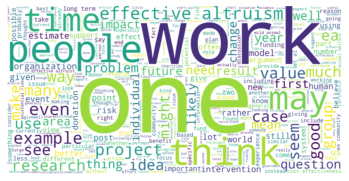

In [18]:
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white', width= 4000, height = 2000, max_words = 400).generate(cleaned_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
wordcloud.to_file('../../wordclouds/eaforum_wordcloud.jpg')

### Make GPT2 text

In [20]:
with open('../../data/ea_forum/eaforum_for_gpt2.txt', 'w+', encoding='utf-8') as f:
    for _, row in df.iterrows():
        f.write(row['title'] + '\n')
        f.write(row['content'] + '\n')

### Make BOW

In [21]:
# use cleaned text to make bag of words along with ssc
with open('../../data/ssc/ssc_for_BOW.txt', 'r+', encoding='utf-8') as f:
    ssc_cleaned = f.read()

In [22]:
len(cleaned_text)

20198740

In [23]:
corpus = [cleaned_text, ssc_cleaned]
vectorizer = CountVectorizer(analyzer = 'word', lowercase=False, stop_words=None)

In [24]:
bow = vectorizer.fit_transform(corpus)

In [25]:
bow_df = pd.DataFrame(bow.toarray(), index=['ea_forum', 'ssc'], columns=vectorizer.get_feature_names())

In [27]:
bow_df.head()

,__,___,____,______,_______,________,__________,__________________________,______________________________________,______________________________________________,...,ᴀᴅ,ẟp,ノಠل,兼愛,宋庆龄幼儿园,官話,有效利他主义,生化危机,生存危机,老外
ea_forum,3,2,4,0,1,1,0,1,1,3,...,1,1,1,1,0,0,1,1,1,0
ssc,0,3,0,1,0,2,1,0,0,0,...,0,0,0,0,1,1,0,0,0,1


In [28]:
bow_df = bow_df.T
bow_df.to_csv('../../data/eaforum_scc_BOW.csv')